# Time Series Imagery Data with Google Earth Engine

In [100]:
import geemap
import ee
import eemont
import matplotlib.pyplot as plt
import urllib.request
import numpy as np
from PIL import Image
from shapely.geometry import Polygon, LineString, Point
import geopandas as gpd
from datetime import datetime
import requests
import rasterio as rio
import zipfile
import glob
from pathlib import Path

Our workflow is as follows:  
1. Use Sentinel-2 imagery for the time interval (2015-2024)
2. Filter the datast to cover New York City's spatial bounds over the time range
3. Preprocess the imagery
   1. Cloud masking
   2. Extracting RGB bands, NIR for roofs
4. Export GEE imagery as GeoTIFFs or numpy arrays for SAM input

## Access time-series imagery

In [26]:
# authenticate if needed
ee.Authenticate()

# initialize the Earth Engine library
ee.Initialize(project='nyc-development')

# Define Brooklyn boundary
nyc = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.And(
    ee.Filter.inList('NAME',[
        'New York', 'Kings', 'Queens', 'Bronx', 'Richmond']),
    ee.Filter.eq('STATEFP', '36')
    )
)

# visualize NYC boundaries
Map = geemap.Map()
Map.centerObject(nyc, 11)
Map.addLayer(nyc, {'color': 'cornflowerblue'}, 'NYC Boroughs')
Map

Map(center=[40.66381799523255, -73.93856333744463], controls=(WidgetControl(options=['position', 'transparent_…

In [27]:
# save the geometry
geemap.ee_export_vector(nyc, filename='data/nyc_boundaries.geojson')

Generating URL ...
Please wait ...
Data downloaded to /Users/sra/files/projects/urban_development_analysis/data/nyc_boundaries.geojson


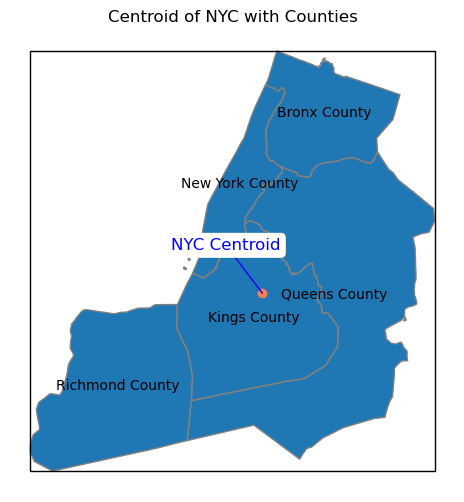

In [116]:
nyc_shape = gpd.read_file('data/nyc_boundaries.geojson')
nyc_merge = nyc_shape.unary_union
nyc_centroid = nyc_merge.centroid
nyc_envelope = nyc_merge.envelope
nyc_merge_gdf = gpd.GeoDataFrame([{'geometry': nyc_merge}], crs=nyc_shape.crs)
centroid_gdf = gpd.GeoDataFrame([{'geometry': nyc_centroid}], crs=nyc_shape.crs)
nyc_envelope_gdf = gpd.GeoDataFrame([{'geometry': nyc_merge.envelope}],
                                    crs=nyc_shape.crs)

fig, ax = plt.subplots(1,1, figsize=(6,6))
nyc_merge_gdf.plot(ax=ax)
centroid_gdf.plot(ax=ax, color='coral', label='Centroid of NYC')
nyc_shape.plot(ax=ax, edgecolor='grey', facecolor='none', label='NYC Counties')
for idx, row in nyc_shape.iterrows():
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, row['NAMELSAD'], 
            fontsize=10, ha='center', color='black')
nyc_envelope_gdf.plot(ax=ax, edgecolor='black', facecolor='none')

label_x = nyc_centroid.x - 0.05  # move east
label_y = nyc_centroid.y + 0.05  # move north
ax.text(label_x, label_y, 'NYC Centroid', 
        fontsize=12, color='blue', ha='center', va='center',
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')) # white background
# add a line connecting the centroid to the label
ax.plot([nyc_centroid.x, label_x], 
        [nyc_centroid.y, label_y], color='blue', linestyle='-', linewidth=1)

# plt.legend()
plt.title('Centroid of NYC with Counties')
plt.axis('off')
plt.show()

The following code is adapted from [this](https://colab.research.google.com/github/st-howard/blog-notebooks/blob/main/Google_Earth_Engine/Satellite%20Imagery%20with%20Google%20Earth%20Engine.ipynb#scrollTo=8678e8e5) Colab notebook.

Get a collection of images using the envelope from NYC calculated above:

In [129]:
# authenticate if needed
ee.Authenticate()

# initialize the Earth Engine library
ee.Initialize(project='nyc-development')

# Define Brooklyn boundary
az = ee.FeatureCollection("TIGER/2018/Counties").filter(
    ee.Filter.And(
    ee.Filter.inList('NAME',[
        'Maricopa']),
    ee.Filter.eq('STATEFP', '04')
    )
)

# visualize NYC boundaries
Map = geemap.Map()
Map.centerObject(az, 11)
Map.addLayer(az, {'color': 'cornflowerblue'}, 'Arizona - Maricopa County')
Map

Map(center=[33.34805419347459, -112.49301604405863], controls=(WidgetControl(options=['position', 'transparent…

<Axes: >

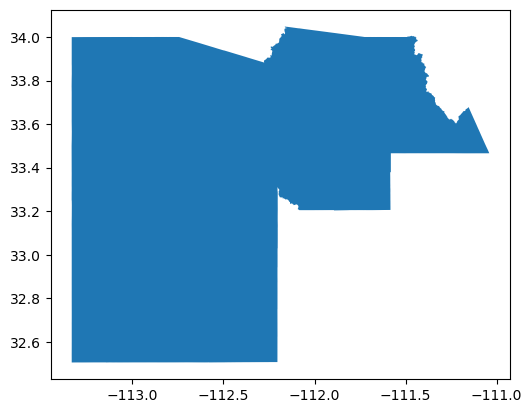

In [134]:
maricopa_shape.plot()

Generating URL ...
Please wait ...
Data downloaded to /Users/sra/files/projects/urban_development_analysis/data/maricopa_boundaries.geojson


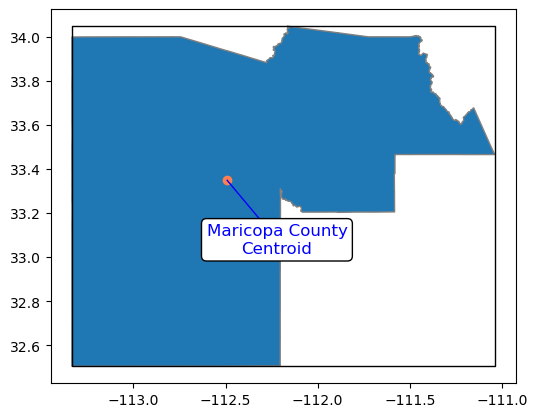

In [153]:
# save the geometry
geemap.ee_export_vector(az, filename='data/maricopa_boundaries.geojson')

maricopa_shape = gpd.read_file('data/maricopa_boundaries.geojson')
maricopa_merge = maricopa_shape.unary_union
maricopa_centroid = maricopa_merge.centroid
maricopa_envelope = maricopa_merge.envelope
maricopa_merge_gdf = gpd.GeoDataFrame([{'geometry': maricopa_merge}], 
                                      crs=maricopa_shape.crs)
maricopa_centroid_gdf = gpd.GeoDataFrame([{'geometry': maricopa_centroid}], 
                                         crs=maricopa_shape.crs)
maricopa_envelope_gdf = gpd.GeoDataFrame([{'geometry': maricopa_merge.envelope}],
                                    crs=maricopa_shape.crs)

fig, ax = plt.subplots(1,1, figsize=(6,6))
maricopa_shape.plot(ax=ax)
maricopa_centroid_gdf.plot(ax=ax, color='coral') #, label='Centroid of Maricopa County, AZ')
maricopa_shape.plot(ax=ax, edgecolor='grey', facecolor='none') #, label='Maricopa County')
# for idx, row in maricopa_shape.iterrows():
#     centroid = row['geometry'].centroid
#     ax.text(centroid.x, centroid.y, row['NAMELSAD'], 
#             fontsize=10, ha='center', color='black')
# maricopa_envelope_gdf.plot(ax=ax, edgecolor='black', facecolor='none')

label_x = maricopa_centroid.x + 0.27  # move east
label_y = maricopa_centroid.y - 0.27  # move north
ax.text(label_x, label_y, 'Maricopa County\nCentroid', 
        fontsize=12, color='blue', ha='center', va='center',
        bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')) # white background
# add a line connecting the centroid to the label
ax.plot([maricopa_centroid.x, label_x], 
        [maricopa_centroid.y, label_y], color='blue', linestyle='-', linewidth=1)

# plt.legend()
# plt.title('Centroid of Maricopa County')
# plt.axis('off')
plt.show()

In [119]:
# convert envelope to GeoJSON
mc_envelope_geojson = gpd.GeoSeries([nyc_envelope]).__geo_interface__['features'][0]['geometry']

# convert GeoJSON to Earth Engine Geometry
nyc_envelope_ee = ee.Geometry(nyc_envelope_geojson)

# filter for NAIP images (high resolution)
nyc_collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(nyc_envelope_ee)
    # .filterDate("2020-01-01", "2021-01-01")
    .filter(ee.Filter.lte("CLOUDY_PIXEL_PERCENTAGE", 5))
)

In [120]:
num_images = nyc_collection.size().getInfo()
if num_images > 0:
    print(f"There are {num_images} NAIP images available for the area.")
else:
    print("No NAIP imagery is available for the defined area.")

There are 650 NAIP images available for the area.


In [122]:
# get the date range of the collection
time_range = nyc_collection.reduceColumns(
    ee.Reducer.minMax(), ["system:time_start"]
).getInfo()

start_date = ee.Date(time_range['min']).format("YYYY-MM-dd").getInfo()
end_date = ee.Date(time_range['max']).format("YYYY-MM-dd").getInfo()

print(f"Sentinel-2 imagery is available from {start_date} to {end_date}.")

Sentinel-2 imagery is available from 2018-03-19 to 2024-12-22.


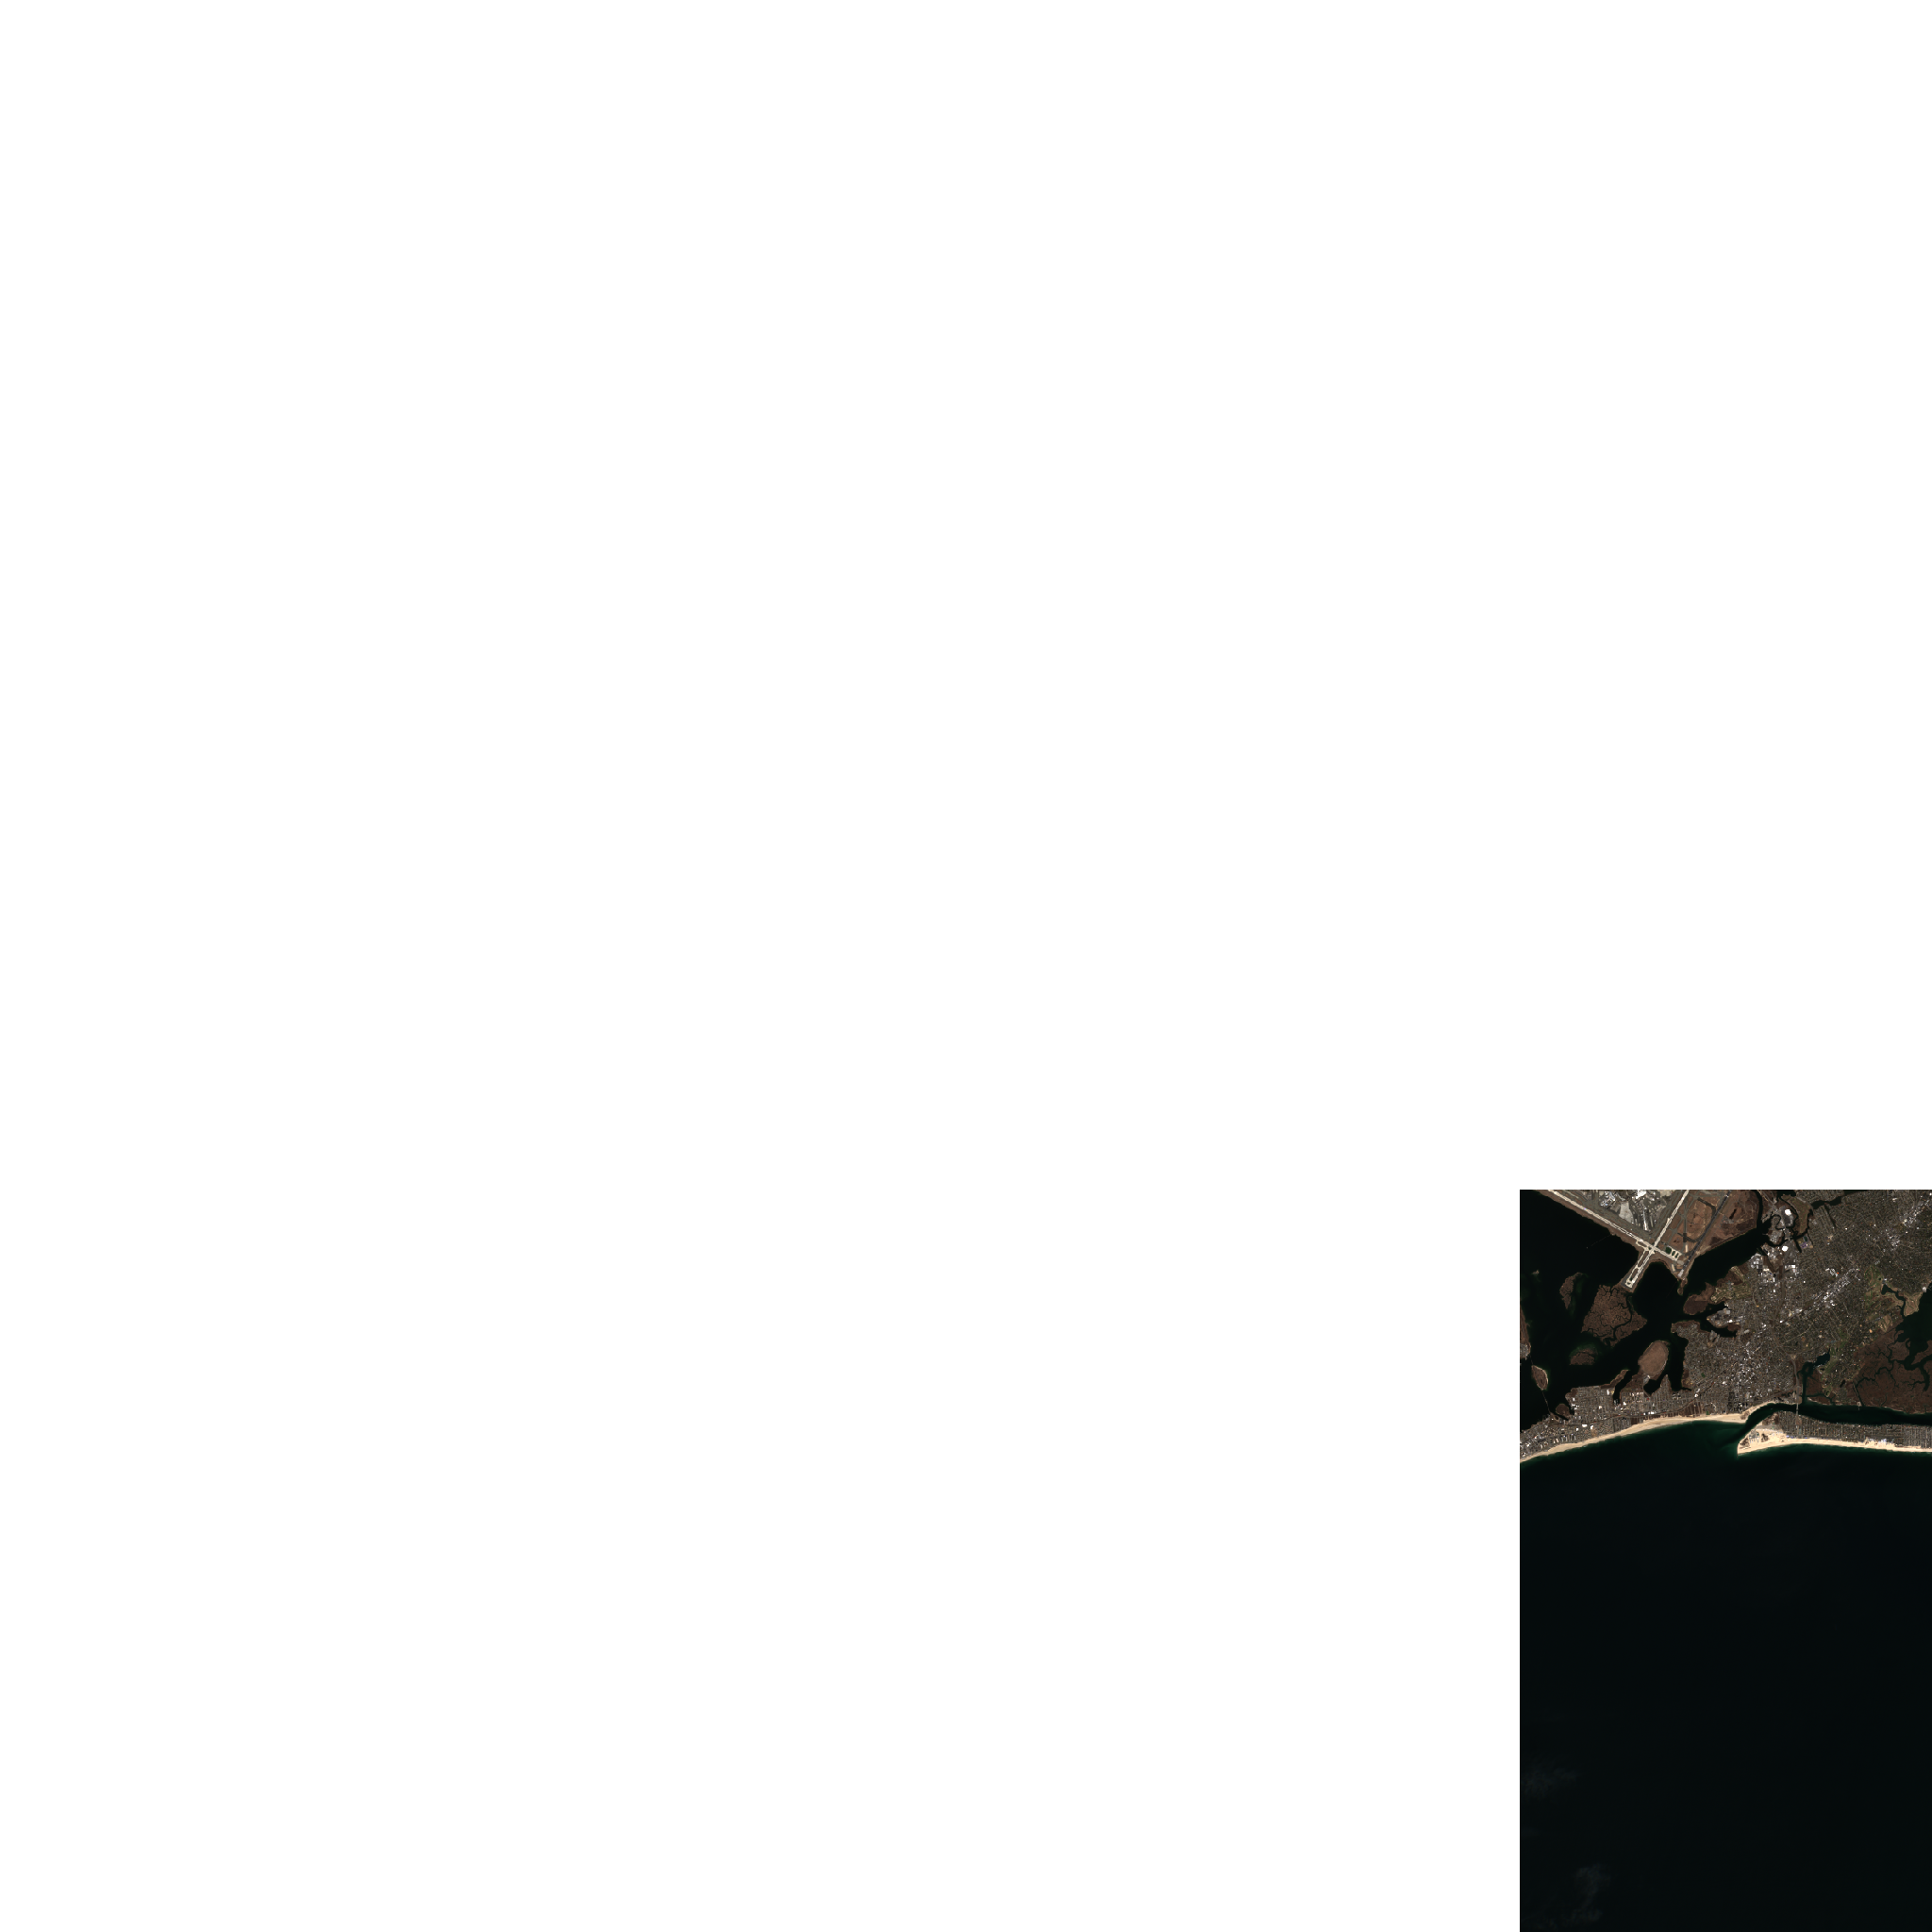

In [128]:
nyc_image_first = nyc_collection.first()  # get the first image

nyc_url = nyc_image_first.getThumbURL(
    {
        "format": "png",
        "bands": ["B4", "B3", "B2"],
        "dimensions": [2048, 2048],
        "region": nyc_envelope_ee,
        "min": 0,
        "max": 4000,
    }
)

nyc_thumburl_response = requests.get(nyc_url, stream=True)
nyc_pil = Image.open(nyc_thumburl_response.raw)
nyc_pil

In [82]:
nyc_image = ee.Image(nyc_collection.first())
nyc_image_info = nyc_image.getInfo()
print("Image Info is a ", type(nyc_image_info))
print("Fields of Image Info:")
for key in nyc_image_info:
    print(key)

print("Start time of Image:\t", nyc_image_info["properties"]["system:time_start"])

print(
    "Date:\t\t\t",
    datetime.fromtimestamp(
        nyc_image_info["properties"]["system:time_start"] / 1000
    ).strftime("%c"),
)

print("Sentinel ID:\t\t", nyc_image_info["properties"]["DATATAKE_IDENTIFIER"])

Image Info is a  <class 'dict'>
Fields of Image Info:
type
bands
version
id
properties
Start time of Image:	 1579622512742
Date:			 Tue Jan 21 11:01:52 2020
Sentinel ID:		 GS2A_20200121T155551_023932_N02.13


To view an image:

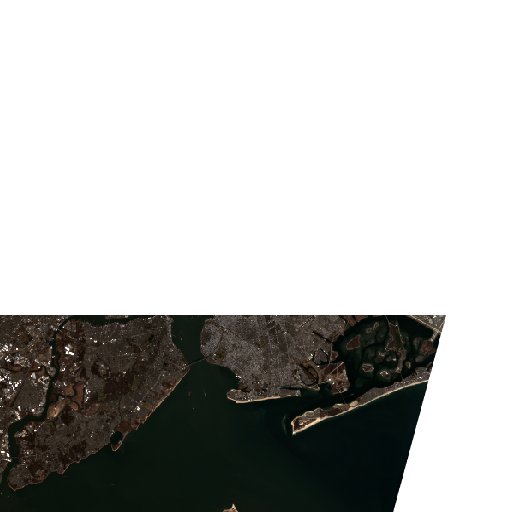

In [85]:
nyc_url = nyc_image.getThumbURL(
    {
        "format": "png",
        "bands": ["B4", "B3", "B2"],
        "dimensions": [512, 512],
        "region": nyc_envelope_ee,
        "min": 0,
        "max": 4000,
    }
)

nyc_thumburl_response = requests.get(nyc_url, stream=True)
nyc_pil = Image.open(nyc_thumburl_response.raw)
nyc_pil

Hey, it's something!

This code below will download an image as a GeoTiff:

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..5.8757102272727275].


Image heigt, width: 512 , 512
Number Bands: 4
Datatype: uint16


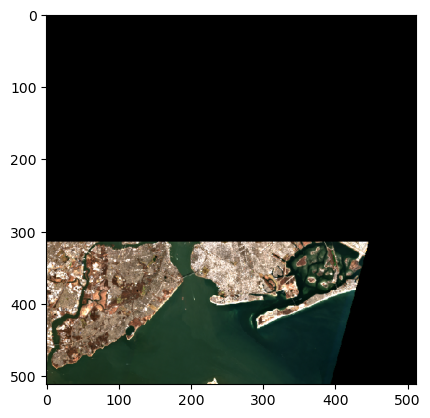

In [89]:
nyc_downloadurl = nyc_image.getDownloadURL(
    {
        "bands": ["B2", "B3", "B4", "B8"],
        "dimensions": [512, 512],
        "region": nyc_envelope_ee,
        "filePerBand": False,
    }
)

nyc_download_response = requests.get(nyc_downloadurl)

with open("nyc_geotiff.zip", "wb") as fd:
    fd.write(nyc_download_response.content)

with zipfile.ZipFile("nyc_geotiff.zip", "r") as zip_ref:
    zip_ref.extractall()

fname = glob.glob("*.tif")

nyc_dataset = rio.open(fname[0])

print("Image heigt, width:", nyc_dataset.height, ",", nyc_dataset.width)
print("Number Bands:", nyc_dataset.count)
print("Datatype:", nyc_dataset.dtypes[0])

nyc_raster = nyc_dataset.read([3, 2, 1])

plt.imshow(np.moveaxis(nyc_raster, 0, -1) / np.percentile(nyc_raster, 99))

Timelapse images of NYC:

In [107]:
# change date filter
nyc_collection = (
    ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED")
    .filterBounds(nyc_envelope_ee)
    .filterDate("2020-01-01", "2021-01-01")
    .filter(ee.Filter.lte("CLOUDY_PIXEL_PERCENTAGE", 5))
    .filter(ee.Filter.gt("MEAN_SOLAR_ZENITH_ANGLE", 0))  # ensure it's daytime
)

# test example image
nyc_first_image = ee.Image(nyc_collection.first())
nyc_url = nyc_first_image.getThumbURL(
    {
        'format': 'png',
        'bands': ['B4', 'B3', 'B2'],
        'dimensions': [512, 512],
        'region': nyc_envelope_ee,
        'min': 0,
        'max': 3000
    }
)
nyc_first_response = requests.get(nyc_url, stream=True)
nyc_pil = Image.open(nyc_first_response.raw)
# nyc_pil.show()

# loop through images and save them
num_image = nyc_collection.size().getInfo()
nyc_list = nyc_collection.toList(nyc_collection.size())
print(f'Filtered to {num_image} images.')

Path("nyc_20_21/").mkdir(parents=True, exist_ok=True)

for i in range(num_image):
    nyc_image = ee.Image(nyc_list.get(i))
    
    # Calculate min and max values dynamically for each image
    stats = nyc_image.reduceRegion(
        reducer=ee.Reducer.minMax(),
        geometry=nyc_envelope_ee,
        scale=10,
        maxPixels=1e9
    ).getInfo()

    min_val = min(stats['B4_min'], stats['B3_min'], stats['B2_min'])
    # limit max value for better contrast
    max_val = min(max(stats['B4_max'], stats['B3_max'], stats['B2_max']), 3000)

    # Get the thumbnail URL for the current image
    nyc_url = nyc_image.getThumbURL(
        {
            "format": "png",
            "bands": ["B4", "B3", "B2"],
            "dimensions": [512, 512],
            "region": nyc_envelope_ee,
            "min": min_val,
            "max": max_val,
        }
    )

    # Fetch and save the image
    nyc_response = requests.get(nyc_url, stream=True)
    nyc_PIL = Image.open(nyc_response.raw)

    nyc_PIL.save(f"nyc_20_21/nyc_{i:03}.png")

print('Done!')

Filtered to 90 images.


KeyboardInterrupt: 

In [ ]:
point = ee.Geometry.PointFromQuery("Washington DC", user_agent="earth_engine_example")

{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [1830, 1830], 'crs': 'EPSG:32618', 'crs_transform': [60, 0, 499980, 0, -60, 4500000]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32618', 'crs_transform': [10, 0, 499980, 0, -10, 4500000]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32618', 'crs_transform': [10, 0, 499980, 0, -10, 4500000]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32618', 'crs_transform': [10, 0, 499980, 0, -10, 4500000]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [5490, 5490], 'crs': 'EPSG:32618', 'crs_transform': [20, 0, 499980, 0, -20, 4500000

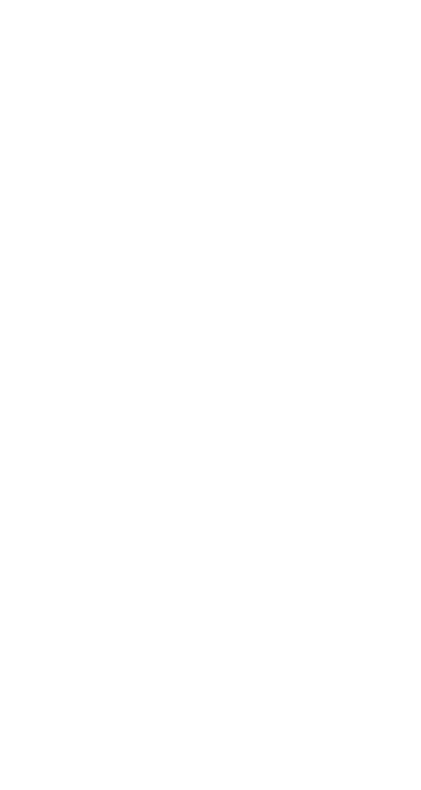

In [24]:
# define Sentinel-2 image collection
sentinel2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(nyc) \
    .filterDate('2023-06-01', '2023-06-30') \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 5))  # filter by cloud cover

# convert the filtered collection into a Python list
image_list = sentinel2.toList(sentinel2.size())

# function to download and plot an image
def plot_ee_image(ee_image, region, vis_params, ax, scale=100):
    """download an earth engine image and plot it using matplotlib."""
    url = ee_image.clip(region).getThumbURL(
        {**vis_params, 'region': region.geometry().getInfo(), 'scale': scale}
    )
    
    # print url to see if the image request is successful
    print("image url:", url)
    
    # open the url and read the image
    with urllib.request.urlopen(url) as response:
        image = Image.open(response)
    
    # convert the image to a numpy array and plot
    ax.imshow(np.array(image))
    ax.axis('off')

# check the image metadata to see if it contains data
image_info = first_image.getInfo()
print(image_info)  # to see metadata about the image

# use a single borough (manhattan) as an example
manhattan = nyc.filter(ee.Filter.eq('NAME', 'New York'))

# visualization parameters for sentinel-2 rgb
vis_params = {
    'bands': ['B4', 'B3', 'B2'],  # rgb bands
    'min': 0,
    'max': 3000,  # adjusted range for sentinel-2 values
}

# plot the first image
fig, ax = plt.subplots(figsize=(10, 10))
plot_ee_image(first_image, manhattan, vis_params, ax, scale=500)  # scale adjusted
plt.show()

In [13]:
print(sentinel2.size().getInfo())  # Outputs the number of images in the filtered collection
image_list = sentinel2.toList(sentinel2.size())
print(image_list.getInfo())  # Lists metadata for the filtered images

6
[{'type': 'Image', 'bands': [{'id': 'B1', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [1830, 1830], 'crs': 'EPSG:32618', 'crs_transform': [60, 0, 499980, 0, -60, 4500000]}, {'id': 'B2', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32618', 'crs_transform': [10, 0, 499980, 0, -10, 4500000]}, {'id': 'B3', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32618', 'crs_transform': [10, 0, 499980, 0, -10, 4500000]}, {'id': 'B4', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [10980, 10980], 'crs': 'EPSG:32618', 'crs_transform': [10, 0, 499980, 0, -10, 4500000]}, {'id': 'B5', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 65535}, 'dimensions': [5490, 5490], 'crs': 'EPSG:32618', 'crs_transform': [20, 0, 499980, 0, -20, 4500

In [ ]:

# Load Landsat imagery (1980–2024)
landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR").filterBounds(nyc)

# Preprocess and visualize
image = landsat.filterDate('2020-01-01', '2020-12-31').median()
Map = geemap.Map()
Map.centerObject(nyc)
Map.addLayer(image, {"bands": ["B4", "B3", "B2"], "min": 0, "max": 3000}, "Landsat")
Map


## Segment buildings

Next is to segment the buildings from the imagery with the SAM (Segment Anything) model:
1. Preprocess imagery to extract building-relevant features
2. Run SAM to segment buildings from each time-step image
3. Save segmentation masks as raster files or NetCDF format

In [ ]:
import torch
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

# Load the SAM model
sam = sam_model_registry["vit_h"](checkpoint="sam_vit_h_4b8939.pth").cuda()
mask_generator = SamAutomaticMaskGenerator(sam)

# Load an image of Brooklyn
import cv2
image = cv2.imread("brooklyn_2020.png")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Generate segmentation masks
masks = mask_generator.generate(image_rgb)

# Save masks for further analysis
import numpy as np
np.save("segmentation_masks_2020.npy", masks)

## Utilize NetCDF for managing time-series data

We will combine the segmentation masks for each time step into a NetCDF file, and use xarray to handle the multi-dimensional data.

In [ ]:
import xarray as xr
import numpy as np

# Combine masks into a NetCDF structure
years = list(range(1980, 2025))
masks = [np.load(f"segmentation_masks_{year}.npy") for year in years]

ds = xr.Dataset(
    {"building_masks": (("time", "x", "y"), masks)},
    coords={"time": years, "x": range(masks[0].shape[0]), "y": range(masks[0].shape[1])}
)

ds.to_netcdf("brooklyn_building_growth.nc")

## Analyze and visualize results

We will calculate the number of buildings or total building area per year.  
We will also create plots to visualize the trends in building growth.

In [ ]:
import matplotlib.pyplot as plt

# Calculate total building area per year
building_area = ds.building_masks.sum(dim=["x", "y"])

# Plot trends
plt.figure(figsize=(10, 6))
plt.plot(ds.time, building_area, label="Total Building Area")
plt.xlabel("Year")
plt.ylabel("Building Area (pixels)")
plt.title("Urban Development in Brooklyn (1980–2024)")
plt.legend()
plt.show()